# Goal
In this notebook we perform 3D registration beteween the Allen Nissl CCF and a MERFISH slice.

# To Dos

Check file paths and see if I can do it in a way that refers only to the repo.

Check indexing W[0], it would be nice to keep this in case of multi channel

# Import necessary libraries

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import tools
import torch
from torch.nn.functional import grid_sample

# Some input arguments

In [2]:
ontology_name = 'allen_ontology.csv'
labelfile = '/home/dtward/data/AllenInstitute/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
imagefile = '/home/dtward/data/AllenInstitute/ara_nissl/ara_nissl_50.nrrd'
labelfile = 'annotation_50.nrrd'
imagefile = 'ara_nissl_50.nrrd'

In [3]:
# device and data type for torch
dtype = torch.float
device = 'cpu'
#device = 'cuda:0'


In [4]:
# key can be SiRj
# where i and j are numbers from 1 to 3
key = 'S2R1'

In [5]:
# pixel size for rasterizing
dx = 30.0

In [6]:
# optimization
niter = 1000
eA = 1e5
ev = 5e8
start3d = 500
startdiff = 800
niter = 3000
#niter = 20  # for testing


sigmaR = 1e9

nt = 2

# Download the Allen atlas ontology

In [7]:
#
if not exists(ontology_name):
    url = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,rma::criteria,[ontology_id$eq1],rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]'
    r = requests.get(url)
    with open(ontology_name,'w') as f:
        f.write(r.text)
O = pd.read_csv(ontology_name)

In [8]:
# store the ontology in a dictionary
namesdict = defaultdict(lambda: 'unk')
namesdict[0] = 'bg'

# we need to add the structure names from the structure_id
for i,n in zip(O['id'],O['acronym']):
    namesdict[i] = n

# Download the Allen atlas image

In [9]:
if not exists(imagefile):
    url = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/ara_nissl/ara_nissl_50.nrrd'
    r = requests.get(url, stream=True)
    with open(imagefile, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                

In [10]:
if not exists(labelfile):
    url = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
    r = requests.get(url, stream=True)
    with open(labelfile, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [11]:
# TODO
# load data in a way that is not specific to my system
files = glob.glob('/mnt/data/merfish/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()

# Define some functions

In [12]:

# build an interp function from grid sample
def interp(x,I,phii,**kwargs):
    '''
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(3):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,3,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

In [13]:
def to_A(L,T):
    O = torch.tensor([0.,0.,0.,1.],device=L.device,dtype=L.dtype)
    return torch.cat((torch.cat((L,T[:,None]),1),O[None]))

In [14]:
def v_to_phii(xv,v):
    '''
    Inputs: 
        xv -> list of 1D tensors describing locations of sample points
        v -> 5D (nt,3,v0,v1,v2) velocity field
    Output:
        phii (inverse map) computed by method of characteristics

    '''
    XV = torch.stack(torch.meshgrid(xv))
    phii = torch.clone(XV)
    dt = 1.0/v.shape[0]
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt
        phii = interp(xv,phii-XV,Xs)+Xs
    return phii

Loading file S2R1


<IPython.core.display.Javascript object>


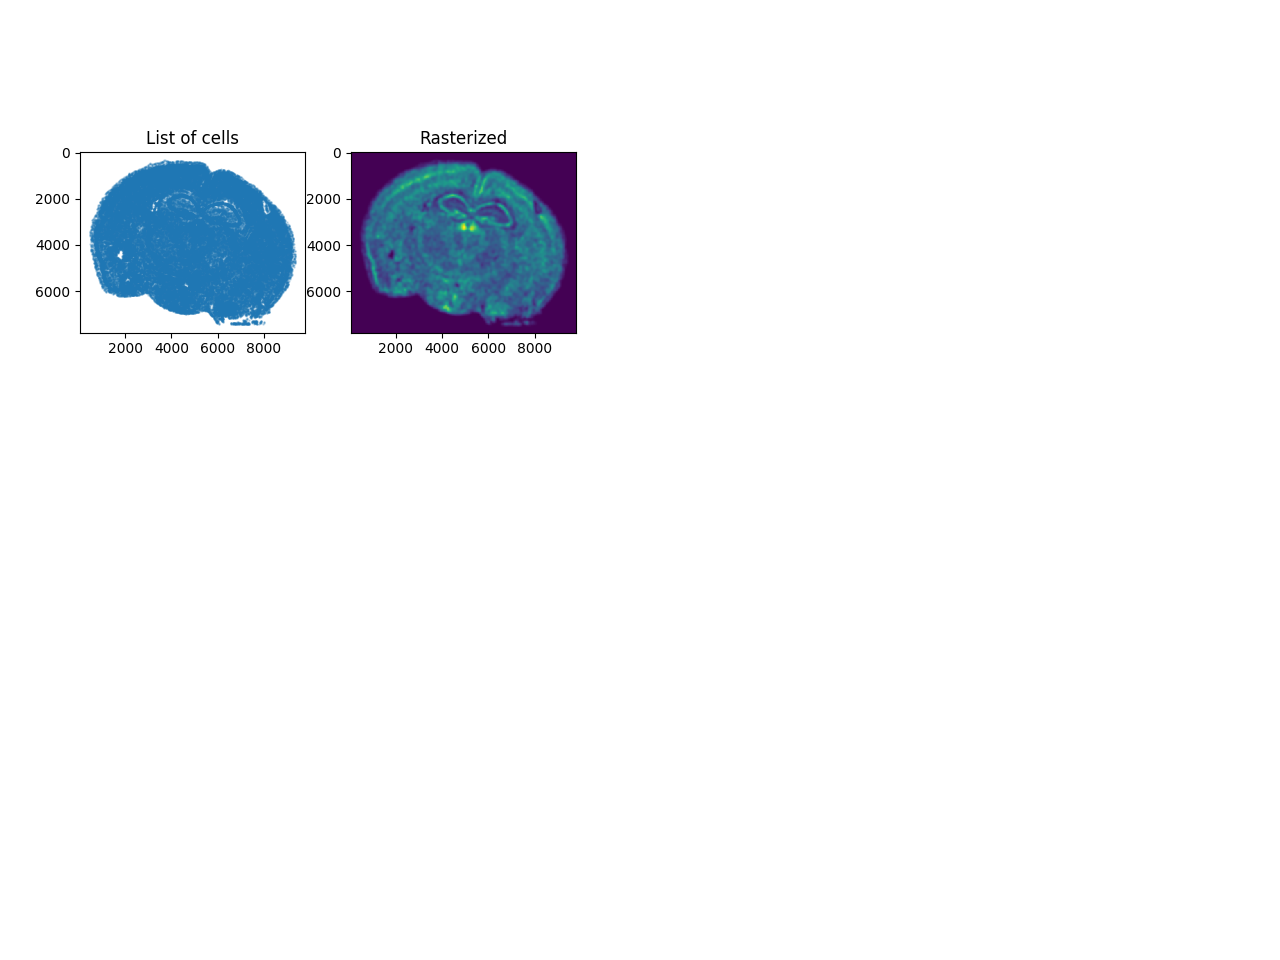

Initialized z translation and rotation to:
270 -0.17453292519943295


<IPython.core.display.Javascript object>

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


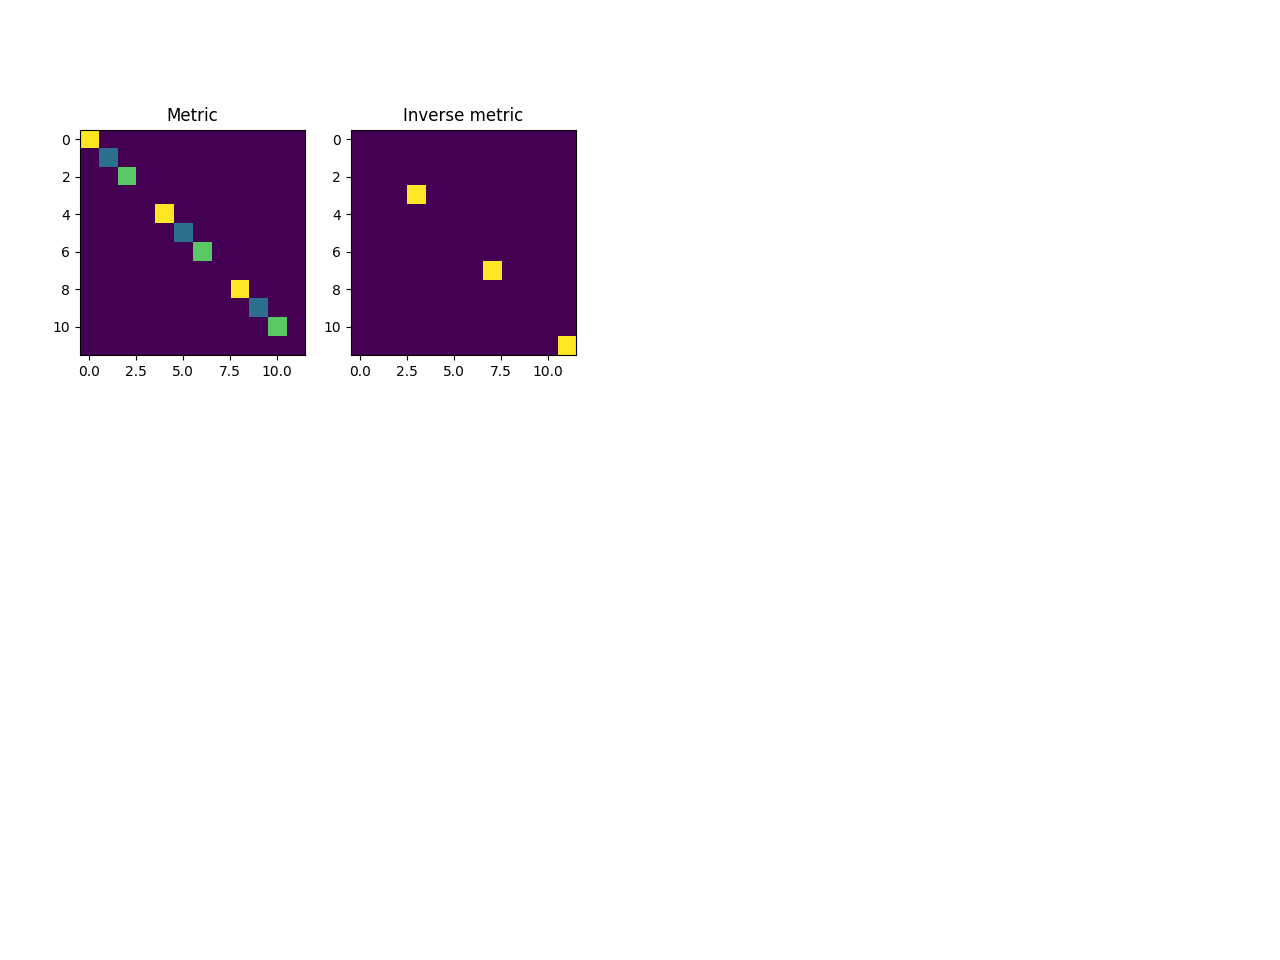

<IPython.core.display.Javascript object>


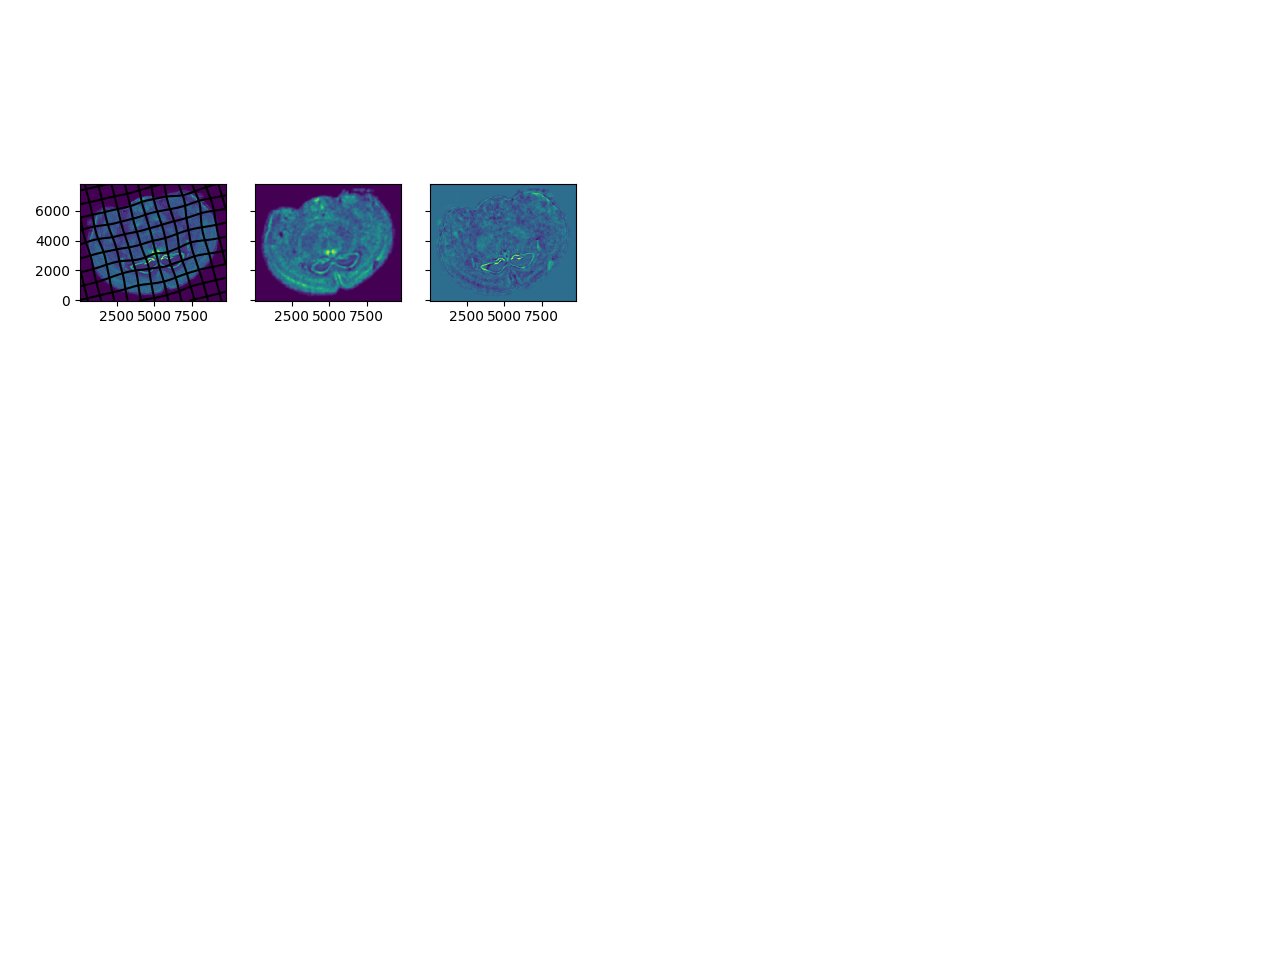

<IPython.core.display.Javascript object>


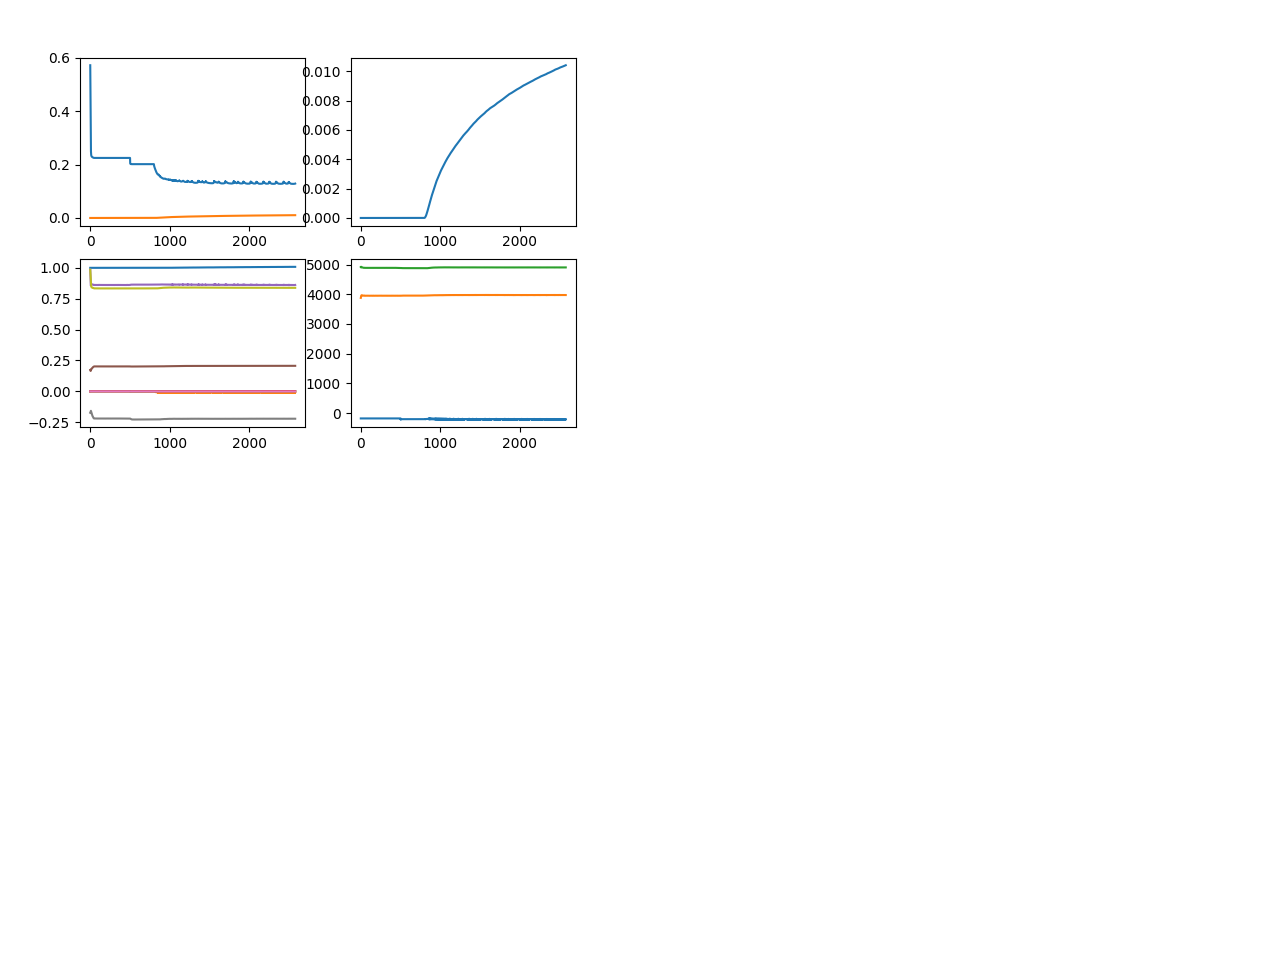

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:221: UserWarning: No contour levels were found within the data range.


In [ ]:
for fname in files:
    if key not in fname:
        continue
    print(f'Loading file {key}')

    names = os.path.splitext(fname)
    if names[1] == '.gz':
        names = os.path.splitext(names[0])
    outname = names[0] + 'tools_v00_with_structure_id.csv'
    outname = names[0] + 'tools_v00_with_structure_id_name.csv'
    
    
    df = pd.read_csv(fname.replace('by_gene','metadata'))
    x = np.array(df['center_x'])
    y = np.array(df['center_y'])
    v = np.array(df['volume'])
    N = x.shape[0]    
        
    fig,ax = plt.subplots(1,2)
    ax[0].scatter(x,y,s=0.5,alpha=0.25)
    ax[0].invert_yaxis()
    ax[0].set_title('List of cells')
    ax[0].set_aspect('equal')
    
    # now we want to rasterize    
    X_,Y_,W = tools.rasterize(x,y,dx=dx,draw=False)     
    W = W[0]
    extent = (X_[0],X_[-1],Y_[0],Y_[-1])    
    ax[1].imshow(W,  origin='lower',extent=extent)    
    ax[1].invert_yaxis()    
    ax[1].set_title('Rasterized')
    
    # save figure
    fig.canvas.draw()    
    fig.savefig(outname[:-4]+'_image.png')
    
    
    # start by loading the atlas

    vol,hdr = nrrd.read(imagefile)
    A = vol    
    vol,hdr = nrrd.read(labelfile)
    L = vol
    
    dxA = np.diag(hdr['space directions'])
    nxA = A.shape
    xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
    XA = np.meshgrid(*xA,indexing='ij')
    
    # we need to get a slice for each
    theta0 = 0.0
    if 'S1R1' in fname:
        slice_ = 350
        theta0 = -10.0*np.pi/180 # negative rotates counter clockwise
    elif 'S1R2' in fname:
        slice_ = 350
        theta0 = 45.0*np.pi/180
    elif 'S1R3' in fname:
        slice_ = 350
        theta0 = 45.0*np.pi/180
    elif 'S2R1' in fname:
        slice_ = 270
        theta0 = -10.0*np.pi/180
    elif 'S2R2' in fname:
        slice_ = 270
        theta0 = -(90+45)*np.pi/180
    elif 'S2R3' in fname:
        slice_ = 270
        theta0 = 180*np.pi/180
    elif 'S3R1' in fname:
        slice_ = 180
        theta0 = 45*np.pi/180
    elif 'S3R2' in fname:
        slice_ = 180
        theta0 = 0.0
    elif 'S3R3' in fname:
        slice_ = 180
        theta0 = -(90+45)*np.pi/180
    print(f'Initialized z translation and rotation to:')
    print(slice_,theta0)
        
    fig,ax = plt.subplots()
    ax.imshow(A[slice_//2],extent=[xA[2][0],xA[2][-1],xA[1][0],xA[1][-1]])
    ax.set_title('Atlas at initial slice')
    
    
    # now we will use torch            
    I = torch.as_tensor(A[None]/np.mean(np.abs(A)),dtype=dtype,device=device)
    J = torch.as_tensor(W[None,None]/np.mean(np.abs(W)),dtype=dtype,device=device)
    xI = [torch.as_tensor(x,dtype=dtype,device=device) for x in xA]
    xJ = [torch.as_tensor([0.0],device=device,dtype=dtype),
          torch.as_tensor(Y_,device=device,dtype=dtype),
          torch.as_tensor(X_,device=device,dtype=dtype)]
    XJ = torch.stack(torch.meshgrid(xJ),-1)
    XI = torch.stack(torch.meshgrid(xI),-1)
    
    # velocity
    dI = torch.tensor([x[1]-x[0] for x in xI])    
    dv = dI*3
    buf = 20
    xv = [torch.arange(x[0]-dIi*buf,x[-1]+dIi*buf,dvi) for x,dIi,dvi in zip(xI,dI,dv)]
    a = dv[0]*3.0
    p = 2.0
    nv = torch.tensor([len(x) for x in xv])
    XV = torch.stack(torch.meshgrid(xv),-1)
    fv = [torch.arange(n)/d/n for n,d in zip(nv,dv)]
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 - 2.0*a**2 * 
                  ( (torch.cos(2.0*np.pi*FV[...,0]*dv[0]) - 1)/dv[0]**2  
                + (torch.cos(2.0*np.pi*FV[...,1]*dv[1]) - 1)/dv[1]**2  
                + (torch.cos(2.0*np.pi*FV[...,2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
    K = 1.0/LL
    
    # metric
    # we'll use the pullback on the points in the atlas    
    g = torch.zeros((12,12))
    count = 0
    for i in range(12):
        Ei = (torch.arange(16)==i).reshape((4,4))*1.0
        EiXI = (Ei[:3,:3]@XI[...,None])[...,0] + Ei[:3,-1]
        for j in range(12):
            Ej = (torch.arange(16)==j).reshape((4,4))*1.0
            EjXI = (Ej[:3,:3]@XI[...,None])[...,0] + Ej[:3,-1]
            g[i,j] = torch.mean(torch.sum(EiXI*EjXI,-1))
     
    gi = torch.inverse(g)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(g)
    ax[0].set_title('Metric') 
    ax[1].imshow(gi)    
    ax[1].set_title('Inverse metric') 
    fig.canvas.draw()

    
    # affine matrix 
    L = torch.eye(3,device=device, dtype=dtype, requires_grad=True)    
    L.data[1,1] = np.cos(theta0)
    L.data[2,1] = np.sin(theta0)
    L.data[1,2] = -np.sin(theta0)
    L.data[2,2] = np.cos(theta0)
    T = torch.zeros(3,device=device,dtype=dtype, requires_grad=True)
    T.data[0] = -xI[0][slice_//2]
    # 
    T.data[1] = np.mean(Y_)
    T.data[2] = np.mean(X_)    
    

    

    
    
    v = torch.zeros((nt,nv[0],nv[1],nv[2],3),requires_grad=True)
    
    
    f0,ax0 = plt.subplots(1,3,sharex=True,sharey=True)
    f1,ax1 = plt.subplots(2,2)
    ax1 = ax1.ravel()

    

    Esave = []
    ERsave = []
    Tsave = []
    Lsave = []
    for it in range(niter):
        # generate
        phii = v_to_phii(xv,v.permute(0,4,1,2,3))
        # apply affine transform to atlas
        A = to_A(L,T)
        # invert
        Ai = torch.inverse(A)
        # sample points
        Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]

        # compose
        Xs = (interp(xv,phii-XV.permute(3,0,1,2),Xs.permute(3,0,1,2)) + Xs.permute(3,0,1,2)).permute(1,2,3,0)

        # transform atlas
        AI = interp(xI,I,Xs.permute(3,0,1,2))
        # contrast
        AI0 = AI - torch.mean(AI)
        if it == 0:
            Jbar = torch.mean(J)
            J0 = J - Jbar
        fAI = AI0 * torch.mean(AI0*J0) / torch.mean(AI0**2) + Jbar
        # cost
        err = fAI-J
        E = torch.mean(err**2)
        #vhat = torch.rfft(v.permute(0,4,1,2,3),3,onesided=False)
        vhat = torch.fft.fftn(v.permute(0,4,1,2,3),dim=(-1,-2,-3))        
        ER = torch.sum(torch.sum(torch.abs(vhat)**2,(0,1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
        E = E + ER
        E.backward()

        Esave.append(E.item())
        ERsave.append(ER.item())
        Lsave.append(L.detach().clone().cpu().numpy().ravel())
        Tsave.append(T.detach().clone().cpu().numpy().ravel())

        # draw
        if not it%10:
            ax0[0].cla()
            ax0[0].imshow(fAI.detach()[0,0].cpu(),extent=extent,origin='lower')
            ax0[1].cla()
            ax0[1].imshow(J.detach()[0,0].cpu(), extent=extent,origin='lower')    
            ax0[2].cla()
            ax0[2].imshow(err.detach()[0,0].cpu(), extent=extent,origin='lower')

            ax1[0].cla()
            ax1[0].plot(Esave)
            ax1[0].plot(ERsave)
            ax1[1].cla()
            ax1[1].plot(ERsave)
            ax1[2].cla()
            ax1[2].plot(Lsave)
            ax1[3].cla()
            ax1[3].plot(Tsave)

            # it would be good to draw the transform
            levels = torch.arange(-10000.0,10000.0,1000.0,device=device,dtype=dtype)    
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,0].detach().cpu().numpy(),levels,colors='k',linestyles='-')
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,1].detach().cpu().numpy(),levels,colors='k',linestyles='-')
            ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,2].detach().cpu().numpy(),levels,colors='k',linestyles='-')

            f0.canvas.draw()
            f1.canvas.draw()
            
        # update
        with torch.no_grad():
            # some heuristicis are used in terms of step sizes
            # combine grads
            grad = torch.cat((L.grad,T.grad[:,None]),-1).reshape(12)
            grad = (gi@grad).reshape(3,4)

            if it > start3d:
                if it == start3d+1:                    
                    eA /= 5                
                L -= grad[:3,:3]*eA
                T -= grad[:3,-1]*eA

            else:                            
                L[1:] -= grad[:3,:3][1:]*eA
                T[1:] -= grad[:3,-1][1:]*eA
            L.grad.zero_()
            T.grad.zero_()

            if it > startdiff:
                #vgrad = torch.irfft(torch.rfft(v.grad.permute(0,4,1,2,3),signal_ndim=3,onesided=False)*K[None,None,...,None],signal_ndim=3,onesided=False).permute(0,2,3,4,1)
                vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad.permute(0,4,1,2,3),dim=(-1,-2,-3))*K[None,None],dim=(-1,-2,-3)).permute(0,2,3,4,1).real
                v -= vgrad*ev
            v.grad.zero_()
            
            
    f0.savefig(outname[:-4]+'_maps.png')
    f1.savefig(outname[:-4]+'_cost.png')
    
    
    # map the annotations
    vol,hdr = nrrd.read(labelfile)
    # we require 64 bit here or there will be trouble
    S = torch.as_tensor(vol.astype(np.float64)[None],dtype=torch.float64,device=device) # note we need float for interp
    AS = torch.round(interp(xI,S,Xs.permute(3,0,1,2).double(),mode='nearest')).int()

    fig,ax = plt.subplots()
    ax.imshow((AS[0,0]%7).detach().cpu().numpy(),
              origin='lower',extent=extent)
    ax.set_title('Labels')
    fig.canvas.draw()
    fig.savefig(outname[:-4]+'_labels.png')
    samples = torch.stack([torch.zeros(len(x),device=device,dtype=dtype),
                           torch.as_tensor(y,device=device,dtype=dtype),
                           torch.as_tensor(x,device=device,dtype=dtype)],-1)  
    
    # here is an update
    col = ((x - X_[0])/dx).astype(int)
    row = ((y - Y_[0])/dx).astype(int)
    out = AS[0,0,row,col]
    out0 = Xs[0,row,col,0]
    out1 = Xs[0,row,col,1]
    out2 = Xs[0,row,col,2]
    
    
    
    # get ready for writing
    # get the variable Xs    
    df['structure_id'] = out
    df['atlas_coord_0'] = out0.detach().cpu()
    df['atlas_coord_1'] = out1.detach().cpu()
    df['atlas_coord_2'] = out2.detach().cpu()
        
    all_names = [namesdict[i] for i in df['structure_id']]
    df['acronym'] = all_names    
    df.to_csv(outname)
    

    
    